In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.optimize
import scipy.spatial
import pandas as pd

import os
import sys
import time

In [2]:
def remove_outlier_runs(data):
    x, y = data[:,0], data[:,1]
    data_wo = []
    for so in np.unique(x):
        rt = np.sort(data[x==so,1])[1:-1]
        data_wo.append(np.c_[so*np.ones_like(rt),rt])
    return np.vstack(data_wo)

def get_data(dataset):
    df = pd.read_csv(dataset)
    data = df.values
    data = remove_outlier_runs(data)
    x, y = data[:,0], data[:,1]/60000.
    return x, y

In [3]:
class InterpolationSplits:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.xu = np.unique(x)[1:-1]
        self.n_iter = self.xu.size
        self.i_iter = 0
    
    def __iter__(self):
        return self
    
    def next(self):
        if self.i_iter == self.n_iter:
            raise StopIteration
            
        m = self.x==self.xu[self.i_iter]
        xtrain, ytrain = self.x[~m], self.y[~m]
        xtest, ytest = self.x[m], self.y[m]
        
        self.i_iter = self.i_iter + 1
        
        return (xtrain, ytrain), (xtest, ytest)
    
    def __len__(self):
        return self.n_iter

class RepeatedRandomSubsampleInterpolationSplits:
    def __init__(self, x, y, n_train, n_iter):
        self.x = x
        self.y = y
        self.xu = np.unique(x)
        self.n_train = n_train
        self.n_iter = n_iter
        self.i_iter = 0
    
    def __iter__(self):
        return self
    
    def next(self):
        if self.i_iter == self.n_iter:
            raise StopIteration
            
        xtrain = np.random.choice(self.xu, size=self.n_train, replace=False)
        xtest_range = np.arange(xtrain.min(), xtrain.max()+1)
        xtest_range = np.intersect1d(xtest_range, self.xu)
        xtest = np.atleast_1d(np.random.choice(xtest_range))

        x = np.r_[xtrain, xtest]
        y = np.array([np.random.choice(self.y[self.x==xi]) for xi in x])
        ytrain, ytest = y[:xtrain.size], y[xtrain.size:]
        
        self.i_iter = self.i_iter + 1
        
        return (xtrain, ytrain), (xtest, ytest)
    
    def __len__(self):
        return self.n_iter

In [4]:
class ProgressBar:
    def __init__(self, it, out=sys.stdout, desc='progress', leave=True, ncols=30):
        self.it = iter(it)
        self.i_iter = 0
        self.n_iter = len(it)
        self.out = out
        self.desc = desc
        self.leave = leave
        self.ncols = ncols

    def _print(self):
        cur = time.time()

        if self.i_iter != 0:
            time_elapsed = cur - self.start
            time_per_it = time_elapsed / self.i_iter
            time_remaining = time_per_it * (self.n_iter - self.i_iter)
        else:
            time_elapsed = 0.
            time_remaining = 0.
        
        rel = float(self.i_iter)/self.n_iter
        cols = int(rel*self.ncols)
        p = '#' * cols + ' ' * (self.ncols-cols)

        fmt = '\r{}: {:3.0f}%|{}| {:{width}d}/{} [{:d}m{:02d}s<{:d}m:{:02d}s]'
        s = fmt.format(self.desc, 100.*rel, p, self.i_iter, self.n_iter,
                       int(1000*time_elapsed)/60000, (int(1000*time_elapsed)%60000)/1000, 
                       int(1000*time_remaining)/60000, (int(1000*time_remaining)%60000)/1000, 
                       width=len(str(self.n_iter)))
    
        self.out.write(s)
        self.out.flush()
        
    def _clear(self):
        self.out.write('\r')
        self.out.flush()
    
    def __len__(self):
        return self.n_iter
    
    def __iter__(self):
        return self
    
    def next(self):
        if self.i_iter == 0:
            self.start = time.time()
            
        self._print()
        
        try:
            _next = self.it.next()
        except StopIteration, e:
            self._print()
            if not self.leave:
                self._clear()
            raise e
        
        self.i_iter = self.i_iter + 1
        return _next

In [5]:
def loss_func(ypred, ytest):
    return np.mean(np.abs((ypred-ytest)/ytest))

def cv_score(models, splits):
    scores = np.zeros((len(models),len(splits)))
    
    for i, ((xtrain, ytrain), (xtest, ytest)) in enumerate(splits):
        for j, model in enumerate(models):
            model.fit(xtrain, ytrain)
            ypred = model.predict(xtest)
            scores[j,i] = loss_func(ypred, ytest)
        
    return scores

## Models

In [6]:
class Ernest:
    def _fmap(self, x):
        return np.c_[np.ones_like(x),1./x,np.log(x),x]
    
    def fit(self, x, y):
        X = self._fmap(x)
        coeff, res = sp.optimize.nnls(X, y)
        self.coeff = coeff
        return self
        
    def predict(self, x):
        X = self._fmap(x)
        return np.dot(X, self.coeff)
    
class KernelReg:
    def __init__(self, bw=None, degree=1, tol=np.finfo(np.float).eps):
        self.bw = bw
        self.degree = degree
        self.tol = tol
        
    def _fmap(self, x):
        return np.vstack([x**i for i in range(self.degree+1)]).T
    
    def _predict_single(self, X, y, x, w):
        XTW = X.T * w
        c = np.linalg.solve(np.dot(XTW, X)+self.tol*np.eye(X.shape[1]), np.dot(XTW, y))
        ypred = np.dot(x, c)
        return ypred
    
    def _predict(self, X, y, Xpred, W):
        n, d = Xpred.shape
        ypred = np.zeros(n)
        for i in range(n):
            ypred[i] = self._predict_single(X, y, Xpred[i], W[i])
        return ypred
    
    def fit(self, x, y):
        if self.bw is None:
            models = [KernelReg(bw=bw) for bw in np.linspace(1, 100, 100)]
            scores = cv_score(models, InterpolationSplits(x, y))
            scores = np.mean(scores, axis=1)
            idx = np.argmin(scores)
            self._bw = models[idx].bw
        else:
            self._bw = self.bw
        
        self.x = x
        self.y = y
        return self
        
    def predict(self, xs):
        xs = np.atleast_1d(xs)
        x, y, h = self.x, self.y, self._bw
            
        D = sp.spatial.distance.cdist(np.atleast_2d(xs).T, np.atleast_2d(x).T, metric='sqeuclidean')
        W = np.exp(-D/(2*h**2))

        X = self._fmap(x)
        X0 = self._fmap(xs)
        
        ypred = self._predict(X, y, X0, W)
        return ypred
    
class AllocationAssistant:
    def __init__(self):
        pass
    
    def fit(self, x, y):
        models = [KernelReg(bw=bw) for bw in np.linspace(1, 100, 100)] + [Ernest()]
        scores = cv_score(models, InterpolationSplits(x, y))
        scores = np.mean(scores, axis=1)
        idx = np.argmin(scores)
        self.model = models[idx]
        return self

    def predict(self, xs):
        return self.model.predict(xs)

## Data Fitting

In [7]:
# runtime data
dpath = 'data/'
fnames = ['grep.spark.csv', 'sgd.spark.csv', 'pagerank.spark.csv', 
          'kmeans.flink.csv', 'tpchq10.flink.csv', 'wordcount.flink.csv']
titles = ['Grep (Spark)', 'SGD (Spark)', 'PageRank (Spark)', 
          'K-Means (Flink)', 'TPC-H Query 10 (Flink)', 'Word Count (Flink)']

# models for fitting
models = [Ernest(), KernelReg()]
labels = ['NNLS', 'LLKR']
colors = ['skyblue', 'lightcoral']

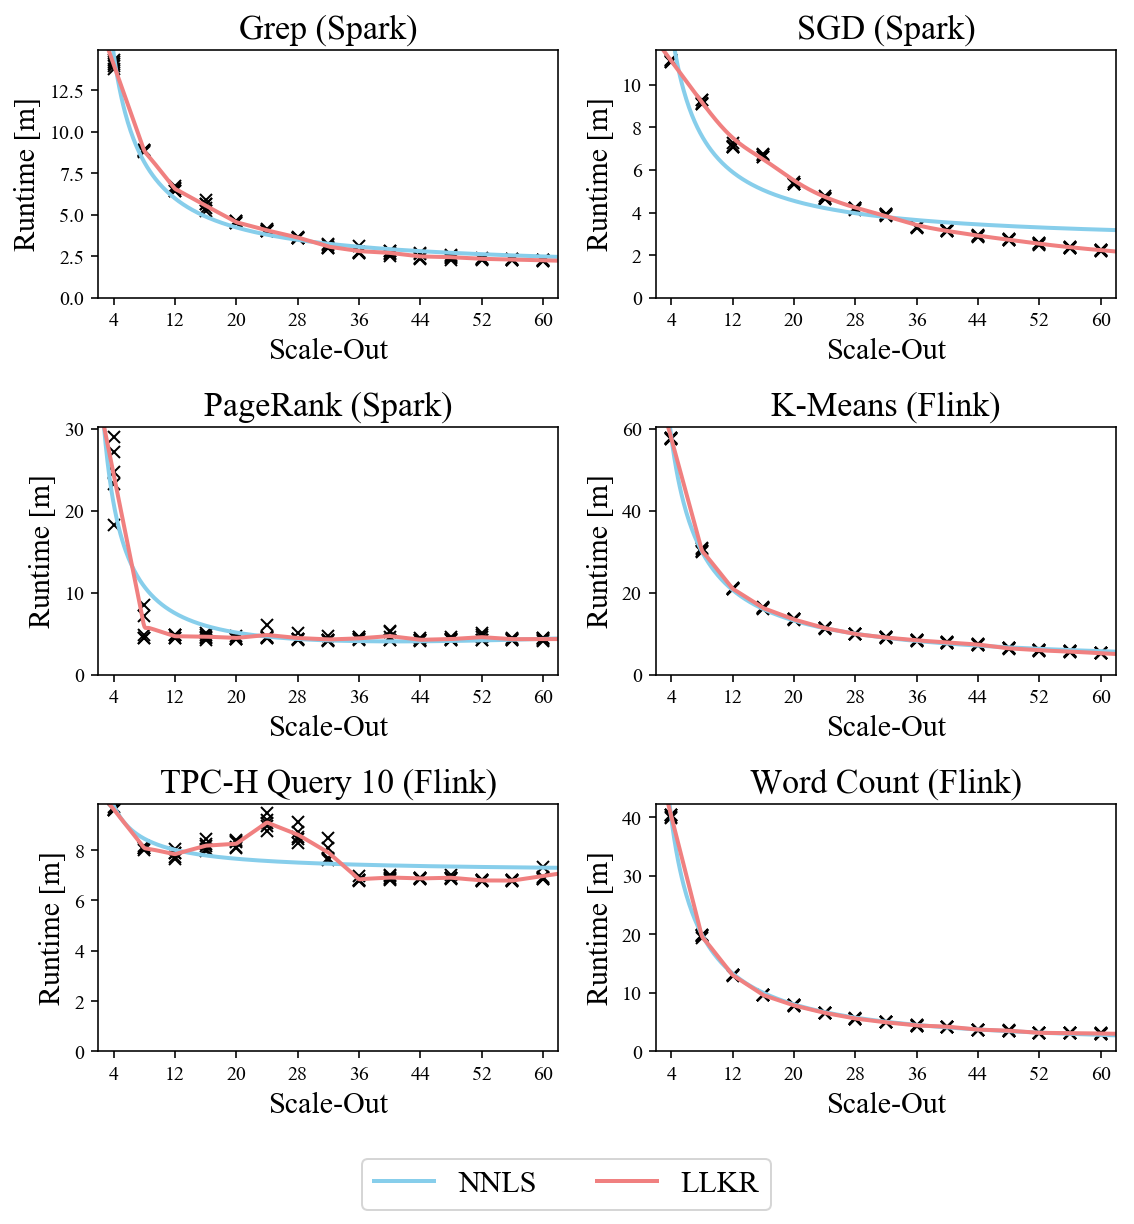

In [8]:
# plot fitted models
mpl.rc('font', family='Times New Roman')
plt.figure(figsize=(8,8))

for i, (fname, title) in enumerate(zip(fnames, titles)):
    fpath = os.path.join(dpath, fname)
    x, y = get_data(fpath)
    
    plt.subplot(3,2,i+1)
    plt.title(title, fontsize=17)
    plt.plot(x, y, 'xk', label='Data')
    plt.xlim(2, 62)
    plt.ylim(ymin=0)

    xpred = np.linspace(2, 62, 500)
    lines = []
    for model, label, color in zip(models, labels, colors):
        model.fit(x, y)
        ypred = model.predict(xpred)
        line = plt.plot(xpred, ypred, label=label, lw=2., c=color)
        plt.xlabel('Scale-Out', fontsize=15)
        plt.ylabel('Runtime [m]', fontsize=15)
        plt.xticks(np.arange(4, 61, 8))
        lines = lines + line
    #plt.legend(loc='best')
        
plt.figlegend(lines, labels, fontsize=15, loc='lower center', ncol=3, bbox_to_anchor=[0.5, -.07], 
              bbox_transform=plt.gcf().transFigure)
plt.tight_layout()    
plt.savefig('figures/predictions.pdf', bbox_inches='tight')
plt.show()

## Learning Curves

In [11]:
# models for learning curves
models = [Ernest(), KernelReg(), AllocationAssistant()]
labels = ['NNLS', 'LLKR', 'Bell']
colors = ['skyblue', 'lightcoral', 'sage']
markers = ['o', 'v', 's']

# learning curve training set sizes
n_train_sizes = np.arange(3,16)

In [10]:
def learning_curve(models, x, y, n_train_sizes, n_iter=100, progress=False):
    curve = []
    for n_train in n_train_sizes:
        splits = RepeatedRandomSubsampleInterpolationSplits(x, y, n_train, n_iter)
        if progress:
            splits = ProgressBar(splits, desc='n=%d'%n_train, leave=False)
        scores = cv_score(models, splits)
        curve.append(scores)
    return np.dstack(curve).transpose(0,2,1)

curves = []
for fname in fnames:
    print fname
    start = time.time()
    
    fpath = os.path.join(dpath, fname)
    x, y = get_data(fpath)
    curve = learning_curve(models, x, y, n_train_sizes, n_iter=2000, progress=True)
    curves.append(curve)
    
    elapsed = time.time() - start
    print '... done in %dm%02ds.' % (int(1000*elapsed)/60000, (int(1000*elapsed)%60000)/1000)
np.savez_compressed('data/learning_curves.npz', **dict(zip(fnames,curves)))

grep.spark.csv
... done in 70m51s.
sgd.spark.csv
... done in 71m03s.
pagerank.spark.csv
... done in 70m47s.
kmeans.flink.csv
... done in 70m50s.
tpchq10.flink.csv
... done in 70m55s.
wordcount.flink.csv
... done in 71m01s.


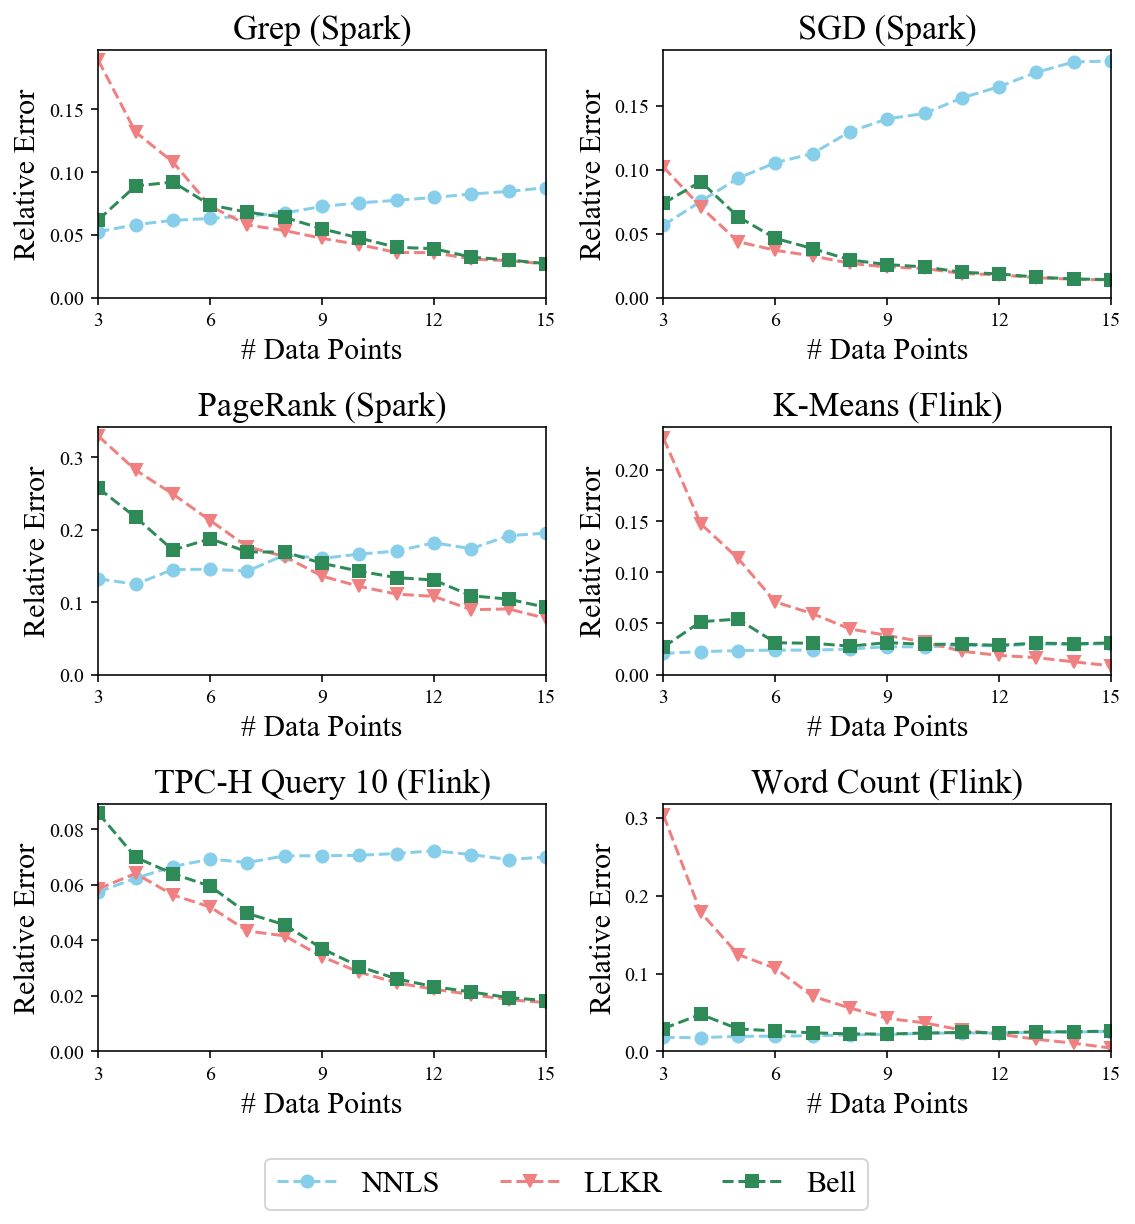

In [12]:
# load saved learning curves
data = np.load('data/learning_curves.npz')
curves = [data[fname] for fname in fnames]

# plot
fig = plt.figure(figsize=(8,8))
for i, (curve, title) in enumerate(zip(curves, titles)):
    d = np.mean(curve, axis=2)
    plt.subplot(3,2,i+1)
    plt.title(title, fontsize=17)
    plt.xlabel('# Data Points', fontsize=15)
    plt.ylabel('Relative Error', fontsize=15)
    lines = []
    for j, (label, color, marker) in enumerate(zip(labels, colors, markers)):
        line = plt.plot(np.arange(3,16), d[j,:], ls='--', marker=marker, c=color, label=label)
        lines = lines + line
    #plt.legend(loc='best')
    plt.xlim(3,15)
    plt.xticks(np.arange(3,16,3))
    plt.ylim(ymin=0)
plt.figlegend(lines, labels, fontsize=15, loc='lower center', ncol=3, bbox_to_anchor=[0.5, -.07], 
              bbox_transform=plt.gcf().transFigure)
plt.tight_layout()
plt.savefig('figures/learning_curves.pdf', bbox_inches='tight')
plt.show()

NNLS
[ 0.05631678  0.06013464  0.06825529  0.0711861   0.07212889  0.07988765
  0.08210311  0.08446152  0.08799802  0.09179749  0.09295402  0.09735653
  0.09896497]
LLKR
[ 0.20225139  0.14588625  0.11593118  0.09209843  0.0734758   0.06422093
  0.05370108  0.04732273  0.04016528  0.03754824  0.03147287  0.02938925
  0.02485035]
Bell
[ 0.08927802  0.09441016  0.0790962   0.07080549  0.06337786  0.05979373
  0.0541833   0.04970611  0.04571045  0.04406203  0.03909085  0.03733251
  0.03491822]


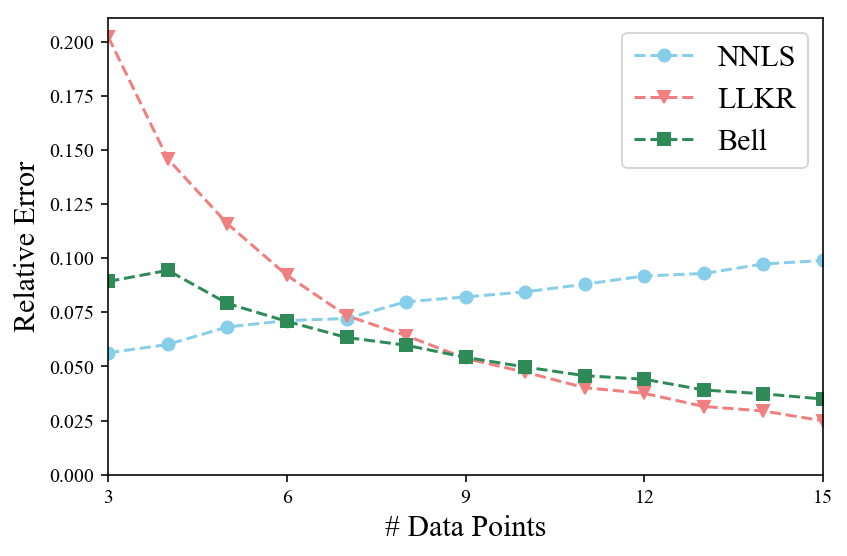

In [24]:
d = np.dstack(curves)
d = np.mean(d, axis=2)
# plt.title('A', fontsize=17)
plt.xlabel('# Data Points', fontsize=15)
plt.ylabel('Relative Error', fontsize=15)
for j, (label, color, marker) in enumerate(zip(labels, colors, markers)):
    print label
    print d[j,:]
    plt.plot(np.arange(3,16), d[j,:], ls='--', marker=marker, c=color, label=label)
plt.xlim(3,15)
plt.xticks(np.arange(3,16,3))
plt.ylim(ymin=0)
    
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('figures/learning_curves_avg.pdf')
plt.show()